In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python


import numpy as np # linear algebra
import pandas as pd # data processing

# graphing/visualization package
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning packages
import sklearn
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay

import xgboost
from xgboost import XGBClassifier


# packages for bayesian optimization
import skopt
from skopt import BayesSearchCV
from skopt.space import Real, Integer

import warnings
warnings.filterwarnings('ignore')

In [2]:
# check package versions
print('numpy version is:{}'.format(np.__version__))
print('pandas version is:{}'.format(pd.__version__))
print('matplotlib version is:{}'.format(matplotlib.__version__))
print('seaborn version is:{}'.format(sns.__version__))
print('scikit-learn version is:{}'.format(sklearn.__version__))
print('xgboost version is:{}'.format(xgboost.__version__))
print('scikit-optimize version is:{}'.format(skopt.__version__))

numpy version is:1.26.4
pandas version is:2.2.3
matplotlib version is:3.7.2
seaborn version is:0.12.2
scikit-learn version is:1.2.2
xgboost version is:2.0.3
scikit-optimize version is:0.10.2


In [3]:
# look at training data

train_df= pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')

# look at training data
print('Training Data')
print(train_df.head())
print('training data shape is:{}'.format(train_df.shape))

Training Data
   id  Gender        Age    Height      Weight family_history_with_overweight  \
0   0    Male  24.443011  1.699998   81.669950                            yes   
1   1  Female  18.000000  1.560000   57.000000                            yes   
2   2  Female  18.000000  1.711460   50.165754                            yes   
3   3  Female  20.952737  1.710730  131.274851                            yes   
4   4    Male  31.641081  1.914186   93.798055                            yes   

  FAVC      FCVC       NCP        CAEC SMOKE      CH2O SCC       FAF  \
0  yes  2.000000  2.983297   Sometimes    no  2.763573  no  0.000000   
1  yes  2.000000  3.000000  Frequently    no  2.000000  no  1.000000   
2  yes  1.880534  1.411685   Sometimes    no  1.910378  no  0.866045   
3  yes  3.000000  3.000000   Sometimes    no  1.674061  no  1.467863   
4  yes  2.679664  1.971472   Sometimes    no  1.979848  no  1.967973   

        TUE       CALC                 MTRANS           NObeyesdad

Mix of numeric and categorical features.

In [4]:
# check null in training data

train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

Training data has no null values.

value counts for training target
NObeyesdad
Obesity_Type_III       4046
Obesity_Type_II        3248
Normal_Weight          3082
Obesity_Type_I         2910
Insufficient_Weight    2523
Overweight_Level_II    2522
Overweight_Level_I     2427
Name: count, dtype: int64


Text(0.5, 1.0, 'Training Target')

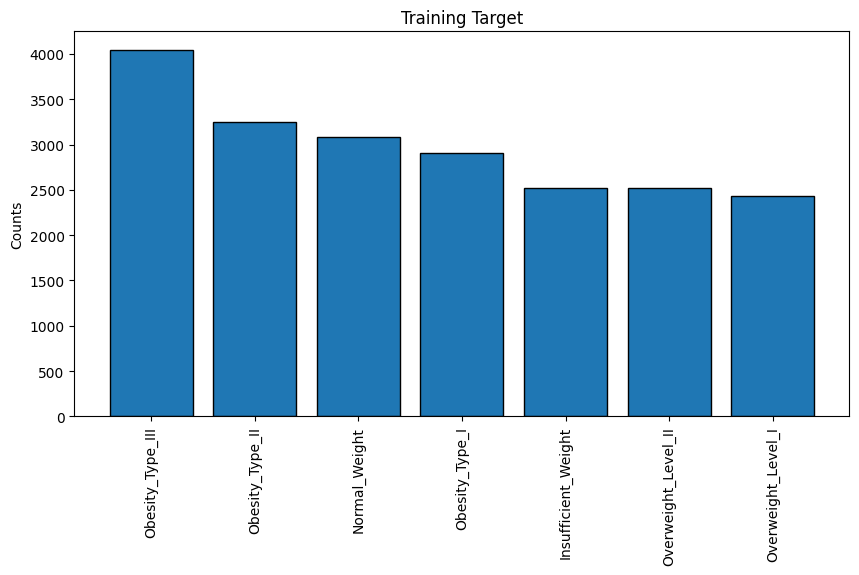

In [5]:
# look at training target

print('value counts for training target')
print(train_df['NObeyesdad'].value_counts())

# get labels and value counts
labels= train_df['NObeyesdad'].value_counts().index.tolist()
counts= train_df['NObeyesdad'].value_counts().values

# plot counts per category
fig1= plt.figure(figsize= (10, 5))
ax1= plt.gca()
ax1.bar(np.arange(len(labels)), counts, align= 'center', edgecolor= 'k')
ax1.set_xticks(np.arange(len(labels)))
ax1.set_xticklabels(labels, rotation= 90)
ax1.set_ylabel('Counts')
ax1.set_title('Training Target')

There are 7 classes for training target.  Classes are balanced.

In [6]:
# look at statistics for numeric features

# make bmi column
train_df['BMI']= train_df['Weight'] / (train_df['Height']**2)

# get numeric columns
num_col= sorted(train_df.select_dtypes(include= np.number).columns.tolist())

# look at statistics for numeric columns
train_df[num_col].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,20758.0,23.841804,5.688072,14.000000,20.000000,22.815416,26.000000,61.000000
BMI,20758.0,30.241842,8.333932,12.868541,24.088223,29.384757,37.011168,54.997991
CH2O,20758.0,2.029418,0.608467,1.000000,1.792022,2.000000,2.549617,3.000000
FAF,20758.0,0.981747,0.838302,0.000000,0.008013,1.000000,1.587406,3.000000
FCVC,20758.0,2.445908,0.533218,1.000000,2.000000,2.393837,3.000000,3.000000
Height,20758.0,1.700245,0.087312,1.450000,1.631856,1.700000,1.762887,1.975663
NCP,20758.0,2.761332,0.705375,1.000000,3.000000,3.000000,3.000000,4.000000
TUE,20758.0,0.616756,0.602113,0.000000,0.000000,0.573887,1.000000,2.000000
Weight,20758.0,87.887768,26.379443,39.000000,66.000000,84.064875,111.600553,165.057269
id,20758.0,10378.500000,5992.462780,0.000000,5189.250000,10378.500000,15567.750000,20757.000000


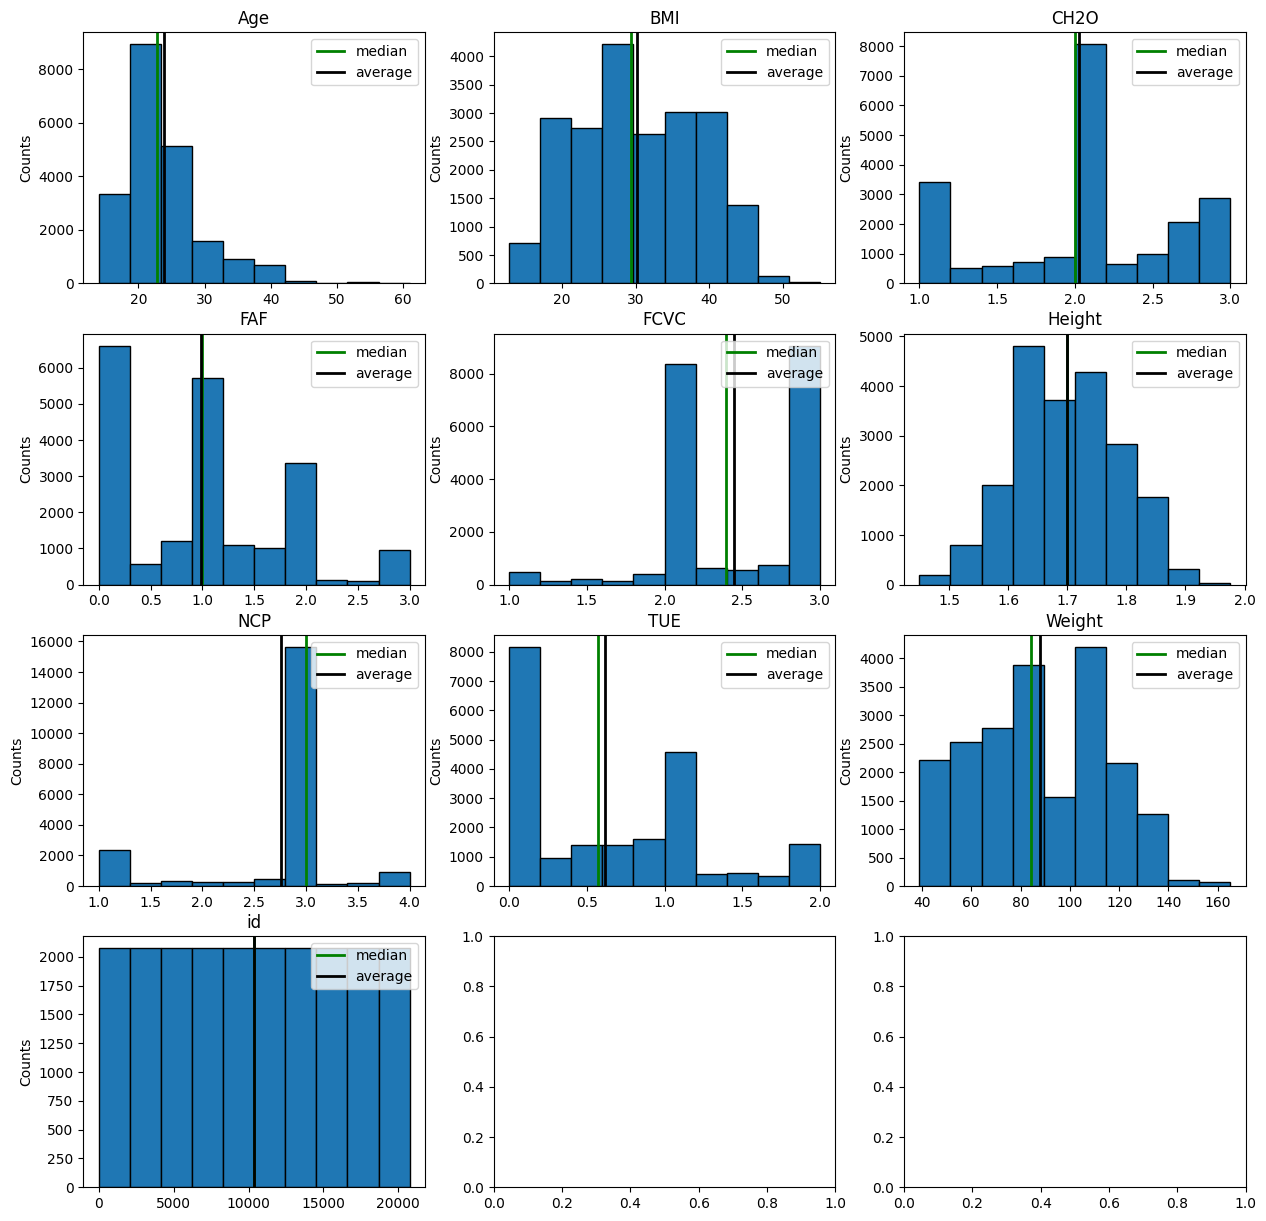

In [7]:
# look at distributions for numeric features

# make figure with subplots
fig2, ax2= plt.subplots(4, 3, figsize= (15, 15))
# initialize counter
count2= 0
# setup loops
for i in range(4):
    for j in range(3):
        if count2 < len(num_col):
            # define subplots and formatting 
            ax2[i, j].hist(train_df[num_col[count2]], edgecolor= 'k')
            ax2[i, j].set_ylabel('Counts')
            ax2[i, j].set_title(num_col[count2])
            # add median to plot
            ax2[i, j].axvline(train_df[num_col[count2]].median(), color= 'green', linewidth= 2, label= 'median')
            # add mean to plot
            ax2[i, j].axvline(train_df[num_col[count2]].mean(), color= 'k', linewidth= 2, label= 'average')
            ax2[i, j].legend(loc= 'upper right')
        # increment counter
        count2= count2 + 1

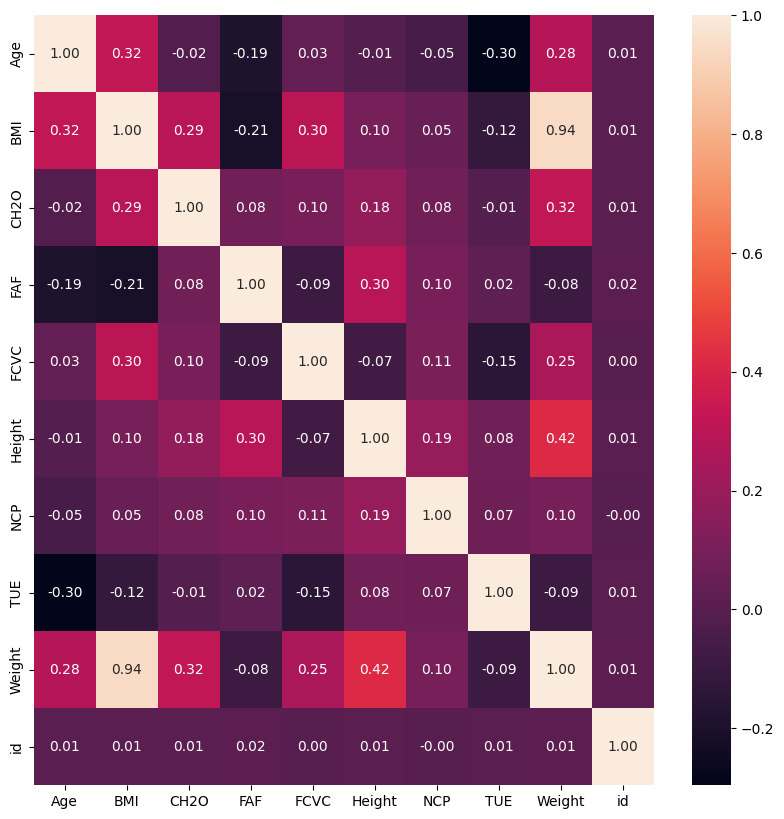

In [8]:
# look at variable correlations for numeric features

fig3= plt.figure(figsize= (10, 10))
fig3= sns.heatmap(train_df[num_col].corr(), annot= True, fmt= '0.2f')

low correlation between numeric features except for BMI and weight.

In [9]:
# look at statistics for categorical features and target

str_col= sorted(train_df.select_dtypes(exclude= np.number).columns.tolist())

train_df[str_col].describe().T

,count,unique,top,freq
CAEC,20758,4,Sometimes,17529
CALC,20758,3,Sometimes,15066
FAVC,20758,2,yes,18982
Gender,20758,2,Female,10422
MTRANS,20758,5,Public_Transportation,16687
NObeyesdad,20758,7,Obesity_Type_III,4046
SCC,20758,2,no,20071
SMOKE,20758,2,no,20513
family_history_with_overweight,20758,2,yes,17014


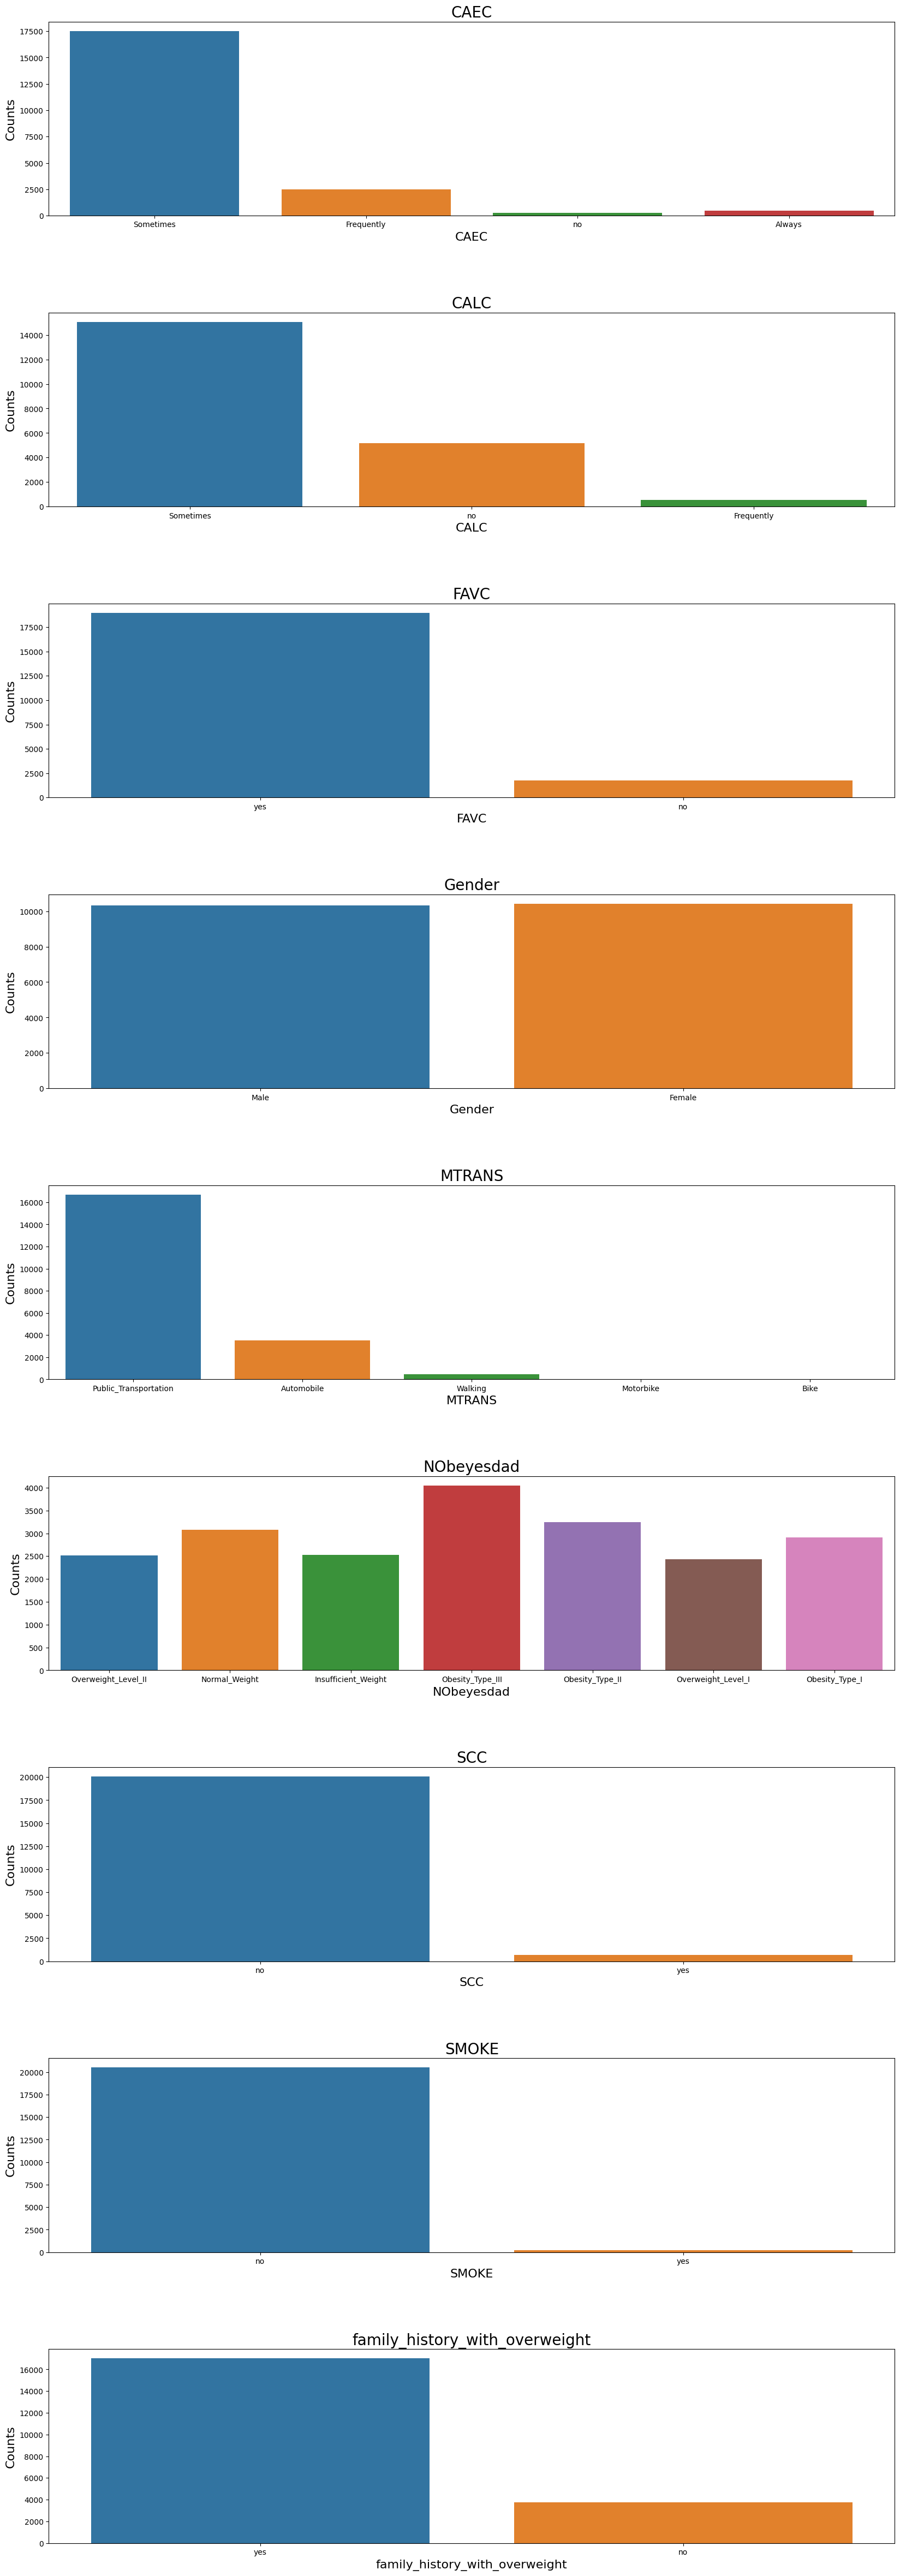

In [10]:
# look at categorical features and target


fig4, ax4= plt.subplots( 9, 1, figsize= (20, 60))
plt.subplots_adjust(hspace= 0.5)
for i in range(9):
    #labels= train_df[str_col[i]].value_counts().index.tolist()
    #counts= train_df[str_col[i]].value_counts().values
    #ax4[i].bar(np.arange(len(labels)), counts, align= 'center', edgecolor= 'k')
    #ax4[i].set_xticks(np.arange(len(labels)))
    #ax4[i].set_xticklabels(labels, rotation= 60, fontsize= 16)
    sns.countplot(train_df, x= str_col[i], ax= ax4[i])
    ax4[i].set_xlabel(str_col[i], fontsize= 16)
    ax4[i].set_ylabel('Counts', fontsize= 16)
    ax4[i].set_title(str_col[i], fontsize= 20)
        

In [11]:
# columns to drop
drop_col= ['id', 'CH2O', 'SMOKE']

# drop columns from dataframe
train_df1= train_df.drop(drop_col, axis= 1)

# look at new dataframe
print('New training dataframe')
print(train_df1.head())
print('Size of new training dataframe is:{}'.format(train_df1.shape))

New training dataframe
   Gender        Age    Height      Weight family_history_with_overweight  \
0    Male  24.443011  1.699998   81.669950                            yes   
1  Female  18.000000  1.560000   57.000000                            yes   
2  Female  18.000000  1.711460   50.165754                            yes   
3  Female  20.952737  1.710730  131.274851                            yes   
4    Male  31.641081  1.914186   93.798055                            yes   

  FAVC      FCVC       NCP        CAEC SCC       FAF       TUE       CALC  \
0  yes  2.000000  2.983297   Sometimes  no  0.000000  0.976473  Sometimes   
1  yes  2.000000  3.000000  Frequently  no  1.000000  1.000000         no   
2  yes  1.880534  1.411685   Sometimes  no  0.866045  1.673584         no   
3  yes  3.000000  3.000000   Sometimes  no  1.467863  0.780199  Sometimes   
4  yes  2.679664  1.971472   Sometimes  no  1.967973  0.931721  Sometimes   

                  MTRANS           NObeyesdad      

In [12]:
# split the training data into training and validation

# separate x and y
y1= train_df1.loc[:, ['NObeyesdad']]
x1= train_df1.drop(['NObeyesdad'], axis= 1)

# split into training and validation
x_train, x_val, y_train, y_val= train_test_split(x1, y1, test_size= 0.2, stratify= y1, shuffle= True)

# reset index for all dataframes
x_train= x_train.reset_index(drop= True)
x_val= x_val.reset_index(drop= True)
y_train= y_train.reset_index(drop= True)
y_val= y_val.reset_index(drop= True)

# look at size of new dataframes
print('Size of x_train is:{}'.format(x_train.shape))
print('Size of x_val is:{}'.format(x_val.shape))
print('Size of y_train is:{}'.format(y_train.shape))
print('Size of y_val is:{}'.format(y_val.shape))

Size of x_train is:(16606, 15)
Size of x_val is:(4152, 15)
Size of y_train is:(16606, 1)
Size of y_val is:(4152, 1)


In [13]:
# scale the numeric columns

# list of numeric columns
num_col1= sorted(x_train.select_dtypes(include= np.number).columns.tolist())

# initialize scaler
scaler= MinMaxScaler()

# fit training data
train_scaled= scaler.fit_transform(x_train[num_col1])
train_scaled= pd.DataFrame(train_scaled, columns= num_col1)

# fit validation data
val_scaled= scaler.transform(x_val[num_col1])
val_scaled= pd.DataFrame(val_scaled, columns= num_col1)

# look at scaled training data
print('Training data scaled')
print(train_scaled.head())

# look at scaled validation data
print('\nValidation data scaled')
print(val_scaled.head())

Training data scaled
        Age       BMI       FAF      FCVC    Height       NCP       TUE  \
0  0.255319  0.661262  0.000000  1.000000  0.395348  0.666667  0.426181   
1  0.187562  0.470178  0.000000  0.500000  0.475902  0.556589  0.937512   
2  0.096797  0.084742  0.666667  0.000000  0.559332  0.908599  0.500000   
3  0.187009  0.366385  0.246878  0.500000  0.439829  0.165592  1.000000   
4  0.190983  0.734808  0.273090  0.985491  0.408536  0.003440  0.517856   

     Weight  
0  0.578572  
1  0.439914  
2  0.087262  
3  0.325249  
4  0.654133  

Validation data scaled
        Age       BMI       FAF  FCVC    Height       NCP       TUE    Weight
0  0.255319  0.634556  0.000000   1.0  0.338262  0.666667  0.254424  0.523067
1  0.191489  0.484936  0.333333   0.5  0.190236  0.666667  0.000000  0.325249
2  0.063830  0.185538  0.000000   1.0  0.399495  0.666667  0.500000  0.142792
3  0.127660  0.198484  1.000000   0.5  0.247307  0.666667  1.000000  0.111061
4  0.163742  0.781034  0.66519

In [14]:
# one hot encode categorical features

# initialize one hot encoder for features
encoder= OneHotEncoder(sparse_output= False, handle_unknown= 'ignore')

# get categorical columns
str_col1= x_train.select_dtypes(exclude= np.number).columns.tolist()

# encode training features
x_train_encoded= encoder.fit_transform(x_train[str_col1])
x_train_encoded= pd.DataFrame(x_train_encoded, columns= encoder.get_feature_names_out())

# encode validation features
x_val_encoded= encoder.transform(x_val[str_col1])
x_val_encoded= pd.DataFrame(x_val_encoded, columns= encoder.get_feature_names_out())

# recombine scaled numeric and encoded categorical features
x_train_done= pd.concat([train_scaled, x_train_encoded], axis= 1)
x_val_done= pd.concat([val_scaled, x_val_encoded], axis= 1)

# look at new training dataframe
print('Training features')
print(x_train_done.head())
print('Shape of training features is:{}'.format(x_train_done.shape))

# look at new validation dataframe
print('\nValidation features')
print(x_val_done.head())
print('Shape of validation features is:{}'.format(x_val_done.shape))

Training features
        Age       BMI       FAF      FCVC    Height       NCP       TUE  \
0  0.255319  0.661262  0.000000  1.000000  0.395348  0.666667  0.426181   
1  0.187562  0.470178  0.000000  0.500000  0.475902  0.556589  0.937512   
2  0.096797  0.084742  0.666667  0.000000  0.559332  0.908599  0.500000   
3  0.187009  0.366385  0.246878  0.500000  0.439829  0.165592  1.000000   
4  0.190983  0.734808  0.273090  0.985491  0.408536  0.003440  0.517856   

     Weight  Gender_Female  Gender_Male  ...  SCC_no  SCC_yes  \
0  0.578572            1.0          0.0  ...     1.0      0.0   
1  0.439914            0.0          1.0  ...     1.0      0.0   
2  0.087262            1.0          0.0  ...     1.0      0.0   
3  0.325249            1.0          0.0  ...     1.0      0.0   
4  0.654133            0.0          1.0  ...     1.0      0.0   

   CALC_Frequently  CALC_Sometimes  CALC_no  MTRANS_Automobile  MTRANS_Bike  \
0              0.0             1.0      0.0                0.

In [15]:
# label encode categorical target

# initialize label encoder for target
encoder1= LabelEncoder()

# encode training target
y_train_encoded= encoder1.fit_transform(y_train)
y_train_encoded= pd.DataFrame(y_train_encoded, columns= ['NObeyesdad'])

# encode validation target
y_val_encoded= encoder1.transform(y_val)
y_val_encoded= pd.DataFrame(y_val_encoded, columns= ['NObeyesdad'])


# look at new dataframes
print('Training target')
print(y_train_encoded.head())
print('Shape of training target is:{}'.format(y_train_encoded.shape))

print('\nValidation target')
print(y_val_encoded.head())
print('Shape of validation target is:{}'.format(y_val_encoded.shape))

Training target
   NObeyesdad
0           4
1           2
2           0
3           6
4           3
Shape of training target is:(16606, 1)

Validation target
   NObeyesdad
0           4
1           6
2           1
3           5
4           4
Shape of validation target is:(4152, 1)


In [16]:
# make function for fit, predict and evaluate classification models

def metric_fn(model1, name1):

    # fitting model to training
    model1.fit(x_train_done, y_train_encoded)
    
    # predict training
    y_pred_train= model1.predict(x_train_done)

    # predict validation
    y_pred_val= model1.predict(x_val_done)

    # evaluate 
    acc_train= accuracy_score(y_train_encoded, y_pred_train)
    acc_val= accuracy_score(y_val_encoded, y_pred_val)
    
    # dataframe with training and validation accuracy scores
    eval_df= pd.DataFrame([[name1, acc_train, acc_val]], columns= ['Model', 'Train Accuracy', 'Val Accuracy'])

    # classification report
    print(classification_report(y_val_encoded, y_pred_val))

    # get target labels
    target_labels= sorted(y_train['NObeyesdad'].unique().tolist())
    # confusion matrix    
    matrix1= ConfusionMatrixDisplay.from_predictions(y_val_encoded, y_pred_val, display_labels= target_labels)
    matrix1.plot(xticks_rotation= 90)
    
    return eval_df

              precision    recall  f1-score   support

           0       0.79      0.79      0.79       505
           1       0.64      0.66      0.65       617
           2       0.78      0.75      0.76       582
           3       0.91      0.94      0.92       650
           4       0.99      1.00      1.00       809
           5       0.56      0.51      0.54       485
           6       0.61      0.63      0.62       504

    accuracy                           0.78      4152
   macro avg       0.75      0.75      0.75      4152
weighted avg       0.78      0.78      0.78      4152


   Model  Train Accuracy  Val Accuracy
0   KNN        0.999458      0.777216


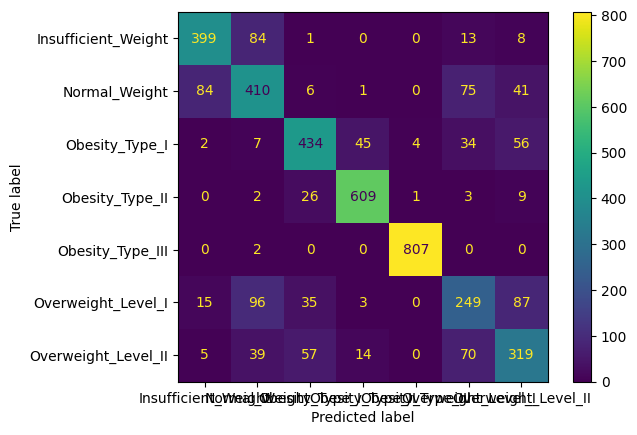

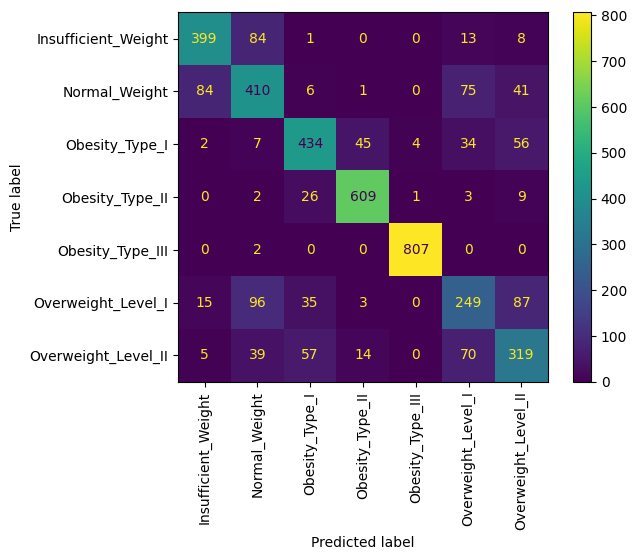

In [17]:
# model 1- KNN

# initialize model
knn1= KNeighborsClassifier(n_neighbors= 3, weights= 'distance')

# dataframe with accuracy scores
compare_df= metric_fn(knn1, 'KNN')

print('\n', compare_df)

KNN model is overfit.

              precision    recall  f1-score   support

           0       0.73      0.94      0.82       505
           1       0.74      0.46      0.57       617
           2       0.35      0.42      0.39       582
           3       0.58      0.97      0.73       650
           4       0.95      1.00      0.97       809
           5       0.72      0.30      0.43       485
           6       0.55      0.31      0.40       504

    accuracy                           0.66      4152
   macro avg       0.66      0.63      0.61      4152
weighted avg       0.68      0.66      0.64      4152


          Model  Train Accuracy  Val Accuracy
0          KNN        0.999458      0.777216
0  Gaussian NB        0.665663      0.661609


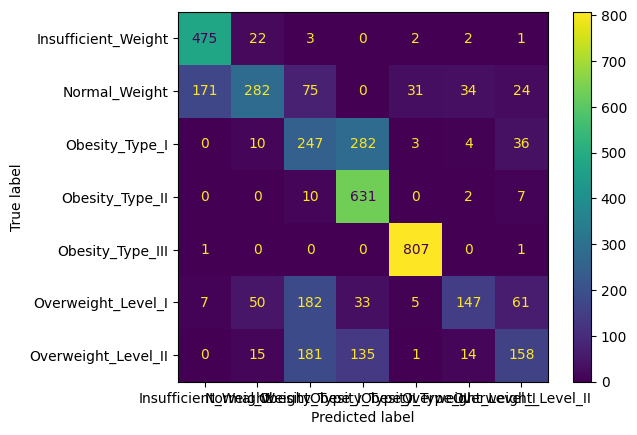

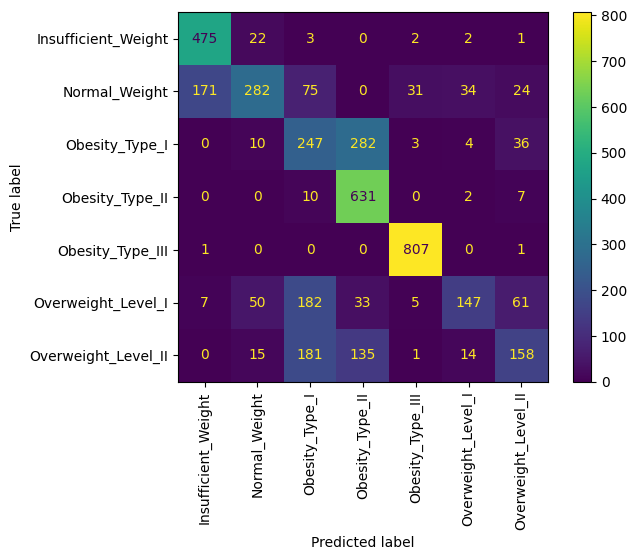

In [18]:
# model 2- gaussianNB

# initialize the model
nb= GaussianNB()

# dataframe with accuracy scores
nb_df= metric_fn(nb, 'Gaussian NB') 

# combine model results
compare_df= pd.concat([compare_df, nb_df], axis= 0)

print('\n', compare_df)


              precision    recall  f1-score   support

           0       0.85      0.92      0.88       505
           1       0.82      0.76      0.79       617
           2       0.86      0.83      0.85       582
           3       0.94      0.97      0.95       650
           4       1.00      1.00      1.00       809
           5       0.71      0.63      0.67       485
           6       0.70      0.78      0.74       504

    accuracy                           0.86      4152
   macro avg       0.84      0.84      0.84      4152
weighted avg       0.85      0.86      0.85      4152


          Model  Train Accuracy  Val Accuracy
0          KNN        0.999458      0.777216
0  Gaussian NB        0.665663      0.661609
0          SVM        0.859208      0.855491


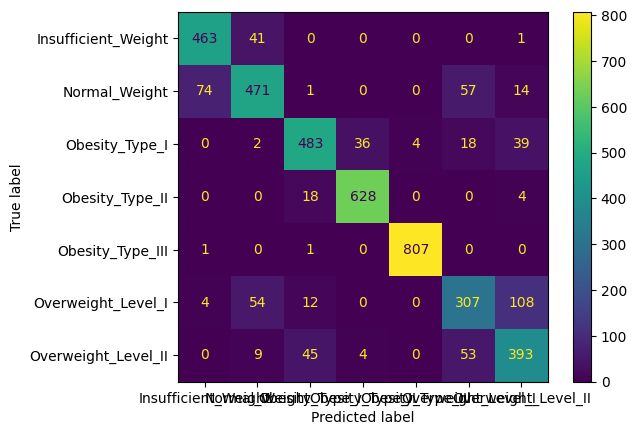

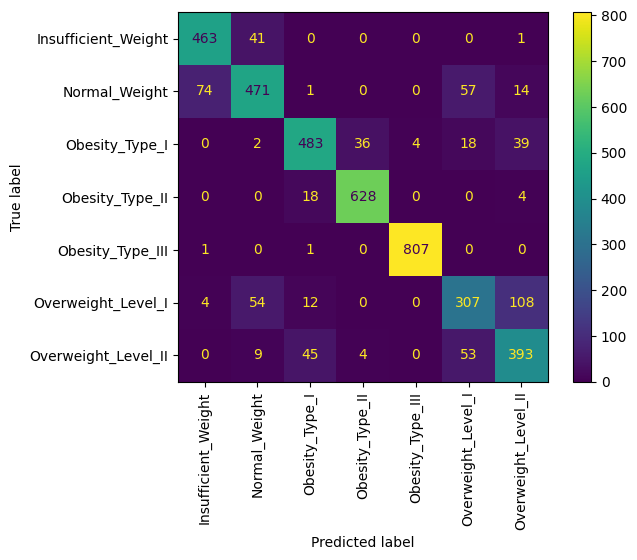

In [19]:
# model 3- SVM

# define SVM model
svc= SVC(decision_function_shape= 'ovo', random_state= 24)

# results for SVM model
svc_df= metric_fn(svc, 'SVM')

# results for all models
compare_df= pd.concat([compare_df, svc_df], axis= 0)

print('\n', compare_df)


              precision    recall  f1-score   support

           0       0.87      0.87      0.87       505
           1       0.76      0.77      0.77       617
           2       0.80      0.82      0.81       582
           3       0.94      0.95      0.95       650
           4       1.00      1.00      1.00       809
           5       0.69      0.64      0.66       485
           6       0.72      0.73      0.72       504

    accuracy                           0.84      4152
   macro avg       0.83      0.83      0.83      4152
weighted avg       0.84      0.84      0.84      4152


            Model  Train Accuracy  Val Accuracy
0            KNN        0.999458      0.777216
0    Gaussian NB        0.665663      0.661609
0            SVM        0.859208      0.855491
0  Decision Tree        0.999458      0.842245


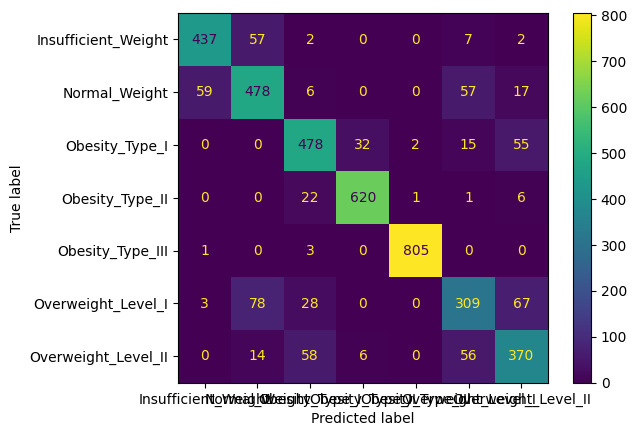

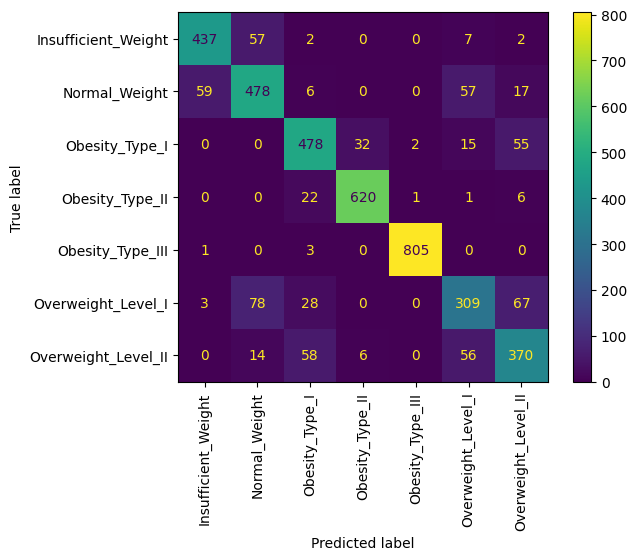

In [20]:
# model 4- decision tree

# initialize model
tree1= DecisionTreeClassifier(criterion= 'entropy', random_state= 24)

# dataframe with model results
tree_df= metric_fn(tree1, 'Decision Tree')

# dataframe to compare models
compare_df= pd.concat([compare_df, tree_df], axis= 0)

print('\n', compare_df)

Decision tree is overfit.

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       505
           1       0.85      0.88      0.87       617
           2       0.90      0.88      0.89       582
           3       0.96      0.97      0.96       650
           4       1.00      1.00      1.00       809
           5       0.83      0.75      0.79       485
           6       0.80      0.82      0.81       504

    accuracy                           0.90      4152
   macro avg       0.89      0.89      0.89      4152
weighted avg       0.90      0.90      0.90      4152


            Model  Train Accuracy  Val Accuracy
0            KNN        0.999458      0.777216
0    Gaussian NB        0.665663      0.661609
0            SVM        0.859208      0.855491
0  Decision Tree        0.999458      0.842245
0  Random Forest        0.999458      0.902457


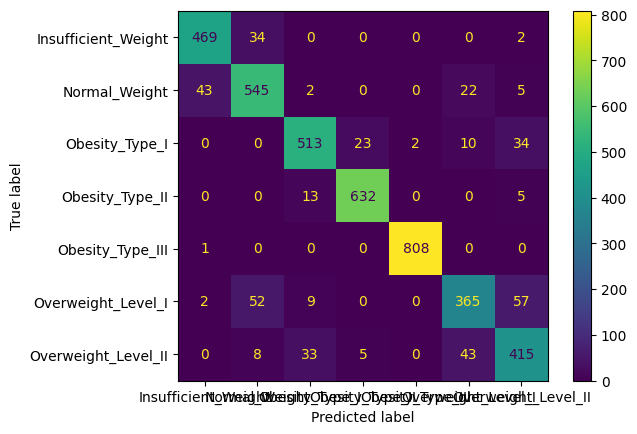

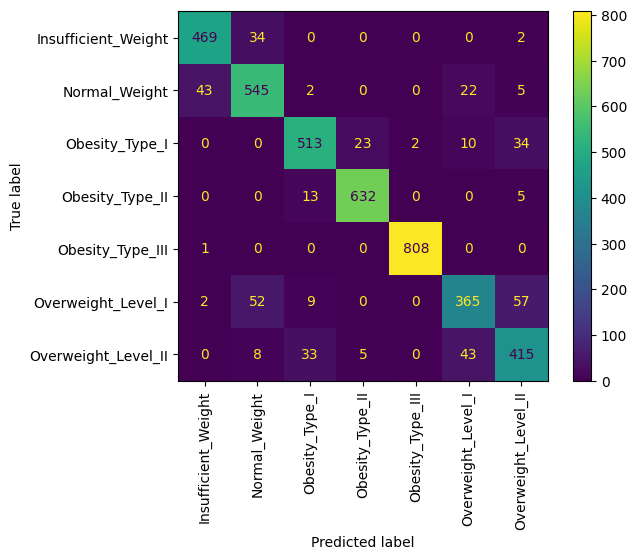

In [21]:
# model 5- random forest

# initialize model
forest1= RandomForestClassifier(criterion= 'entropy', random_state= 24)

# dataframe with model results
forest_df= metric_fn(forest1, 'Random Forest')

# dataframe to compare models
compare_df= pd.concat([compare_df, forest_df], axis= 0)

print('\n', compare_df)

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       505
           1       0.88      0.88      0.88       617
           2       0.91      0.89      0.90       582
           3       0.96      0.98      0.97       650
           4       1.00      1.00      1.00       809
           5       0.83      0.77      0.80       485
           6       0.82      0.85      0.83       504

    accuracy                           0.91      4152
   macro avg       0.90      0.90      0.90      4152
weighted avg       0.91      0.91      0.91      4152


            Model  Train Accuracy  Val Accuracy
0            KNN        0.999458      0.777216
0    Gaussian NB        0.665663      0.661609
0            SVM        0.859208      0.855491
0  Decision Tree        0.999458      0.842245
0  Random Forest        0.999458      0.902457
0        XGBoost        0.986029      0.909441


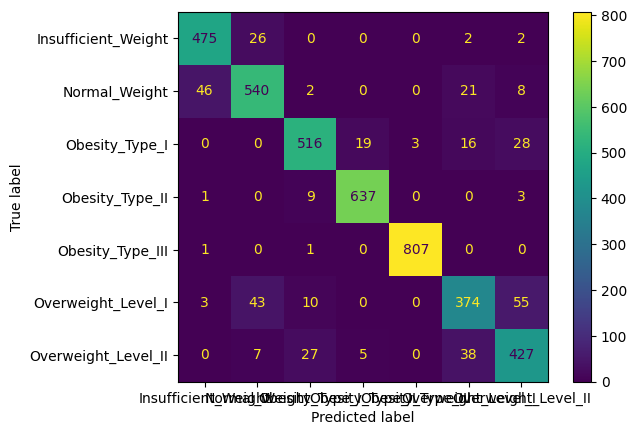

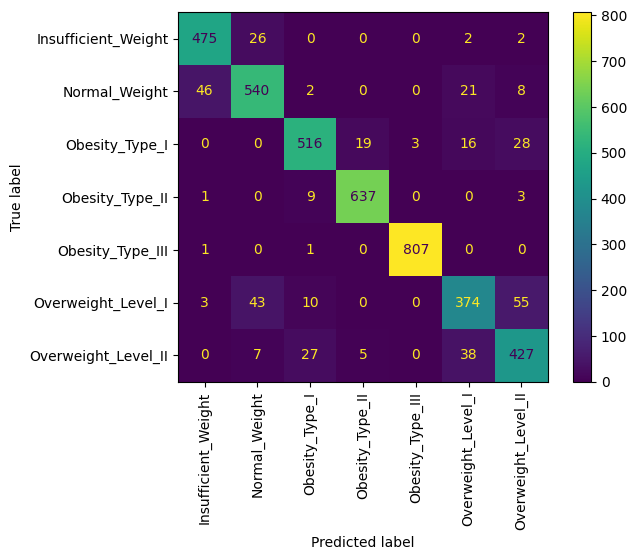

In [22]:
# model 6- xgboost

# initialize model
boost1= XGBClassifier(random_state= 24)

# dataframe with model results
boost_df= metric_fn(boost1, 'XGBoost')

# dataframe to compare all models
compare_df= pd.concat([compare_df, boost_df], axis= 0)

print('\n', compare_df)

Model with best performance (highest validation accuracy) was xgboost.  Will use bayesian optimization to try and further improve model.

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END eta=0.018304382630123395, max_depth=5, n_estimators=1160, subsample=0.7480458987620778; total time=  12.0s
[CV] END eta=0.018304382630123395, max_depth=5, n_estimators=1160, subsample=0.7480458987620778; total time=  12.0s
[CV] END eta=0.018304382630123395, max_depth=5, n_estimators=1160, subsample=0.7480458987620778; total time=  12.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END eta=0.017927737035028483, max_depth=3, n_estimators=1104, subsample=0.9587691365040684; total time=   7.8s
[CV] END eta=0.017927737035028483, max_depth=3, n_estimators=1104, subsample=0.9587691365040684; total time=   7.5s
[CV] END eta=0.017927737035028483, max_depth=3, n_estimators=1104, subsample=0.9587691365040684; total time=   7.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END eta=0.054407469046384056, max_depth=6, n_estimators=959, subsample=0.5627798484043633; total time=  11.2s
[CV] END eta

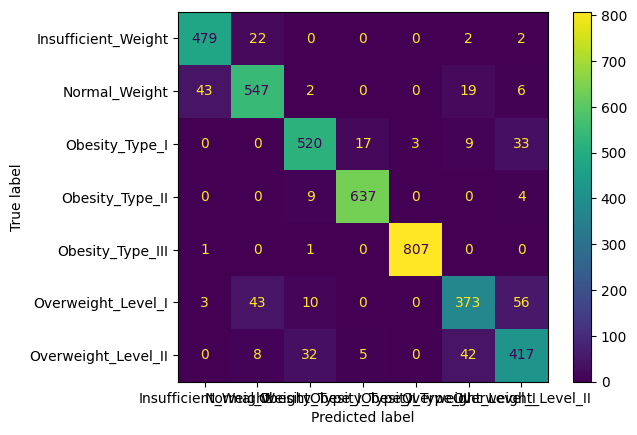

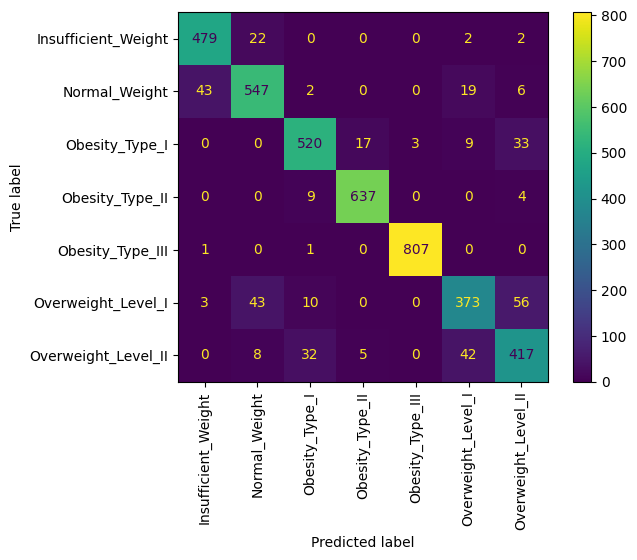

In [23]:
# do bayesseachcv on xgboost
boost2= XGBClassifier(random_state= 24)

param_space= {'eta':Real(0.01, 0.1, prior= 'log-uniform'), 
             'n_estimators':Integer(700, 1200),
             'max_depth':Integer(3, 7),
             'subsample':Real(0.4, 1.0)}

bayes1= BayesSearchCV(estimator= boost2, search_spaces= param_space, n_iter= 100, 
                      scoring= 'accuracy', verbose= 2, cv= 3, random_state= 24)

bayes1.fit(x_train_done, y_train_encoded)

# look at results
print('best parameters:{}'.format(bayes1.best_params_))

# optimized xgboost model
opt_boost= XGBClassifier(eta= bayes1.best_params_['eta'], n_estimators= bayes1.best_params_['n_estimators'], 
                        max_depth= bayes1.best_params_['max_depth'], subsample= bayes1.best_params_['subsample'], 
                        random_state= 24)

# fit, predict and evaluate optimized model
opt_boost_df= metric_fn(opt_boost, 'Opt. XGBoost')

# compare all models
compare_df= pd.concat([compare_df, opt_boost_df], axis= 0)

print('\n', compare_df)

optimized xgboost model has slightly higher accuracy and isn't overfit.

In [24]:
# train model with full training dataset

train_all= train_df.copy()

# separate x and y
y_train_all= train_all.loc[:, ['NObeyesdad']]
x_train_all= train_all.drop(['NObeyesdad'], axis= 1)

# columns to drop
drop_col= ['id', 'CH2O', 'SMOKE']

# drop columns from dataframe
train_all1= x_train_all.drop(drop_col, axis= 1)

# look at new dataframe
print('New training dataframe')
print(train_all1.head())
print('Size of new training dataframe is:{}'.format(train_all1.shape))

New training dataframe
   Gender        Age    Height      Weight family_history_with_overweight  \
0    Male  24.443011  1.699998   81.669950                            yes   
1  Female  18.000000  1.560000   57.000000                            yes   
2  Female  18.000000  1.711460   50.165754                            yes   
3  Female  20.952737  1.710730  131.274851                            yes   
4    Male  31.641081  1.914186   93.798055                            yes   

  FAVC      FCVC       NCP        CAEC SCC       FAF       TUE       CALC  \
0  yes  2.000000  2.983297   Sometimes  no  0.000000  0.976473  Sometimes   
1  yes  2.000000  3.000000  Frequently  no  1.000000  1.000000         no   
2  yes  1.880534  1.411685   Sometimes  no  0.866045  1.673584         no   
3  yes  3.000000  3.000000   Sometimes  no  1.467863  0.780199  Sometimes   
4  yes  2.679664  1.971472   Sometimes  no  1.967973  0.931721  Sometimes   

                  MTRANS        BMI  
0  Public_Tra

In [25]:
# apply same modifications from training to test

test_df= pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')

# need this for submission file
test_id= test_df.loc[:, ['id']]

# add BMI column
test_df['BMI']= test_df['Weight'] / (test_df['Height']**2)

# drop columns
test_df1= test_df.drop(drop_col, axis= 1)

# look at new test dataframe
print('Shape of test dataframe is:{}'.format(test_df1.shape))
print(test_df1.head())

Shape of test dataframe is:(13840, 15)
   Gender        Age    Height      Weight family_history_with_overweight  \
0    Male  26.899886  1.848294  120.644178                            yes   
1  Female  21.000000  1.600000   66.000000                            yes   
2  Female  26.000000  1.643355  111.600553                            yes   
3    Male  20.979254  1.553127  103.669116                            yes   
4  Female  26.000000  1.627396  104.835346                            yes   

  FAVC      FCVC       NCP       CAEC SCC       FAF       TUE       CALC  \
0  yes  2.938616  3.000000  Sometimes  no  0.855400  0.000000  Sometimes   
1  yes  2.000000  1.000000  Sometimes  no  1.000000  0.000000  Sometimes   
2  yes  3.000000  3.000000  Sometimes  no  0.000000  0.250502  Sometimes   
3  yes  2.000000  2.977909  Sometimes  no  0.094851  0.000000  Sometimes   
4  yes  3.000000  3.000000  Sometimes  no  0.000000  0.741069  Sometimes   

                  MTRANS        BMI  
0  

In [26]:
# scale training and test data

# initialize scaler
scaler1= MinMaxScaler()

# find numeric columns
num_col= sorted(test_df1.select_dtypes(include= np.number).columns.tolist())

# fit and transform training data
train_all_scaled= scaler1.fit_transform(train_all1[num_col])
train_all_scaled= pd.DataFrame(train_all_scaled, columns= num_col)

# transform test data
test_scaled= scaler1.transform(test_df1[num_col])
test_scaled= pd.DataFrame(test_scaled, columns= num_col)

# look at scaled training data
print('Training scaled')
print(train_all_scaled.head())

# look at scaled test data
print('Test scaled')
print(test_scaled.head())



Training scaled
        Age       BMI       FAF      FCVC    Height       NCP       TUE  \
0  0.222192  0.365327  0.000000  0.500000  0.475586  0.661099  0.488237   
1  0.085106  0.250503  0.333333  0.500000  0.209260  0.666667  0.500000   
2  0.085106  0.101073  0.288682  0.440267  0.497391  0.137228  0.836792   
3  0.147931  0.759261  0.489288  1.000000  0.496002  0.666667  0.390099   
4  0.375342  0.302178  0.655991  0.839832  0.883049  0.323824  0.465861   

     Weight  
0  0.338497  
1  0.142792  
2  0.088577  
3  0.732007  
4  0.434708  
Test scaled
        Age       BMI       FAF      FCVC    Height       NCP       TUE  \
0  0.274466  0.532807  0.285133  0.969308  0.757698  0.666667  0.000000   
1  0.148936  0.306501  0.333333  0.500000  0.285354  0.000000  0.000000   
2  0.255319  0.675432  0.000000  1.000000  0.367831  0.666667  0.125251   
3  0.148495  0.714664  0.031617  0.500000  0.196185  0.659303  0.000000   
4  0.255319  0.634131  0.000000  1.000000  0.337471  0.666667 

In [27]:
# one hot encode training and test features

# initialize one hot encoder
encoder1= OneHotEncoder(sparse_output= False, handle_unknown= 'ignore')

# find categorical columns
str_col= sorted(test_df1.select_dtypes(exclude= np.number).columns.tolist())

# fit and transform training data
train_all_encoded= encoder1.fit_transform(train_all1[str_col])
train_all_encoded= pd.DataFrame(train_all_encoded, columns= encoder1.get_feature_names_out())

# transform test data
test_encoded= encoder1.transform(test_df1[str_col])
test_encoded= pd.DataFrame(test_encoded, columns= encoder1.get_feature_names_out())

# combine numeric and categorical features
train_final= pd.concat([train_all_scaled, train_all_encoded], axis= 1)
test_final= pd.concat([test_scaled, test_encoded], axis= 1)


# look at scaled and encoded training data
print('Training scaled and one hot encoded')
print(train_final.head())

# look at scaled and encoded test data
print('Test scaled and one hot encoded')
print(test_final.head())

Training scaled and one hot encoded
        Age       BMI       FAF      FCVC    Height       NCP       TUE  \
0  0.222192  0.365327  0.000000  0.500000  0.475586  0.661099  0.488237   
1  0.085106  0.250503  0.333333  0.500000  0.209260  0.666667  0.500000   
2  0.085106  0.101073  0.288682  0.440267  0.497391  0.137228  0.836792   
3  0.147931  0.759261  0.489288  1.000000  0.496002  0.666667  0.390099   
4  0.375342  0.302178  0.655991  0.839832  0.883049  0.323824  0.465861   

     Weight  CAEC_Always  CAEC_Frequently  ...  Gender_Male  \
0  0.338497          0.0              0.0  ...          1.0   
1  0.142792          0.0              1.0  ...          0.0   
2  0.088577          0.0              0.0  ...          0.0   
3  0.732007          0.0              0.0  ...          0.0   
4  0.434708          0.0              0.0  ...          1.0   

   MTRANS_Automobile  MTRANS_Bike  MTRANS_Motorbike  \
0                0.0          0.0               0.0   
1                1.0    

In [28]:
# label encode training target
# initialize encoder
label1= LabelEncoder()

# fit and transform training target
y_train_final= label1.fit_transform(y_train_all)
y_train_final= pd.Series(y_train_final, name= 'NObeyesdad')

# look at transformed target
print('Training target')
print(y_train_final.head())

Training target
0    6
1    1
2    0
3    4
4    6
Name: NObeyesdad, dtype: int64


In [29]:
# fit and predict using optimized xgboost model

# optimized xgboost model
opt_boost1= XGBClassifier(eta= bayes1.best_params_['eta'], n_estimators= bayes1.best_params_['n_estimators'], 
                        max_depth= bayes1.best_params_['max_depth'], subsample= bayes1.best_params_['subsample'], 
                        random_state= 24)

# fit training data
opt_boost1.fit(train_final, y_train_final)

# make predictions on test data
y_test_final= opt_boost1.predict(test_final)
# inverse label encoding to get target labels as strings
y_test_final= label1.inverse_transform(y_test_final)
# make series
y_test_final= pd.Series(y_test_final, name= 'NObeyesdad')

# combine id and predictions
sub_df= pd.concat([test_id, y_test_final], axis= 1)

# look at submission dataframe
print(sub_df.head())

# submit file
sub_df.to_csv('/kaggle/working/submission.csv', index= False)


      id          NObeyesdad
0  20758     Obesity_Type_II
1  20759  Overweight_Level_I
2  20760    Obesity_Type_III
3  20761      Obesity_Type_I
4  20762    Obesity_Type_III
